# Attr HW ISIMIP3b 6 models with hist and hist-nat visualisation

## to do 
extend also to other models 

In [2]:
# necessary: matplotlib, netcdf4-python, regionmask (automatically imports xarray), Cartopy
# check if I can automate this 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
%matplotlib inline
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import cartopy
import cartopy.crs as ccrs
import netCDF4
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1 import AxesGrid

from settings import *
start_message()

from functions import * # move all fxns here when good ! 

indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/ 
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/ 
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0'] 
GCMs p: ['GFDL-ESM4', 'IPSL-CM6A-LR', 'MRI-ESM2-0'] 
GCMs s: ['CanESM5', 'CNRM-CM6-1', 'MIROC6'] 
lat chunk: 90 
lon chunk: 120 
time chunk: -1 
outdir: /data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output 
figdir: /data/brussel/vo/000/bvo00012/vsc10419/attr-hw/figures 
start_pi: 1850 
end_pi: 1900 
flags {'models': 'ISIMIP3b', 'metric': 'TX90', 'method': 'percentile'}


In [4]:
# SETTINGS

figdir = os.path.join(figdirs, 'fig_jun23_isimip3b-tx99')
flag_save = False



## Functions 

In [5]:
# for each subplot

def calc_bounds_PR_power(n, skew=0):
    # calculate bounds maximum bound will be 2**n, skew tells how many you lose from the <1 side
    inds = range(n)
    arr = 2**np.array(inds)
    arr_less = np.flip(np.power(arr.astype(float), -1))
    bounds = list(arr_less)[:-1] +  list(arr)
    bounds = bounds[skew:]
    return bounds

# keep dark blues 
def make_mycmap(cmap, length, skew=0):
    # total length you want including the skew
    # for now max skew is 2, try to get more skew potentially
    cmap = plt.get_cmap(cmap, length-skew) 
    extracols = [colors.to_rgb('#610b0b')] + [colors.to_rgb('#300823')]
    color_list = [colors.rgb2hex(cmap(i)) for i in range(cmap.N)] + extracols
    if len(extracols)-skew >0:
        mycmap = colors.LinearSegmentedColormap.from_list('mycmap', color_list[:-(len(extracols)-skew)], len(color_list[:-(len(extracols)-skew)]))
    elif len(extracols)-skew == 0:
        mycmap = colors.LinearSegmentedColormap.from_list('mycmap', color_list, len(color_list))
    return mycmap
 
# version 2: get rid of dark blues 
def make_mycmap(cmap, length, skew=0):
    # total length you want including the skew
    # for now max skew is 2, try to get more skew potentially
    if cmap == 'RdYlBu_r':
        extracols = [colors.to_rgb('#610b0b')] + [colors.to_rgb('#300823')] # add more colors if you want more skew
    if cmap == 'RdBu_r':
        extracols = [colors.to_rgb('#450707')] + [colors.to_rgb('#300823')]
    
    cmap = plt.get_cmap(cmap, length+skew)
    color_list = [colors.rgb2hex(cmap(i)) for i in range(cmap.N)] + extracols
    if len(extracols)-skew >0:
        mycmap = colors.LinearSegmentedColormap.from_list('mycmap', color_list[skew:-(len(extracols)-skew)], len(color_list[skew:-(len(extracols)-skew)]))
    elif len(extracols)-skew == 0:
        mycmap = colors.LinearSegmentedColormap.from_list('mycmap', color_list[skew:], len(color_list[skew:]))
    return mycmap

# do it also asymmetrically ! so you dont need to remove same skew from left and right...
# like zip the bounds and the colorlist and then slice both! 
def calc_bounds_cmap_PR_power(n, cmap, skew=0):
    bounds = calc_bounds_PR_power(n, skew=skew)
    mycmap = make_mycmap(cmap, len(bounds), skew=skew)
    return bounds, mycmap

def get_mask():
    landmask = xr.open_dataarray('/data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/geo_conditions/landseamask/landseamask_no-ant.nc')[0,:,:].drop_vars('time') # move this path to settings?
    return landmask 


    # option 1 smooth then mask
def plot_PR(GCM, ax, cmap, bounds, smooth=False, mask=False):
    # settings
    q = 0.99
    
    # data 
    outdir = get_outputpaths(GCM)[1]
    data_pi_99 = xr.open_dataarray( glob.glob(os.path.join(outdir,  '{}*1850_1900.nc'.format(GCM.lower())) )[0], engine='netcdf4')
    percentiles_pres_da = xr.open_dataarray(glob.glob(os.path.join(outdir, '{}*percentiles_pres_piTX99*.nc'.format(GCM.lower())))[0])
    PR_da = (1 - percentiles_pres_da) / (1 - q)
    # MODIFY THIS TO USE PR ALREADY CALCULATED AND SAVED ! AND CHECK IT ONLY WITH THE ORIGINAL FILES
    
    # set params
    title = '{}'.format(GCM)
    cmap = cmap #try also RdBu_r
    crs = ccrs.PlateCarree()
    
    # define levels and cmap 
    ticks = levels = bounds 
    norm = colors.BoundaryNorm(levels, cmap.N)
    
    landmask = get_mask()
    
    # smooth and mask data
    if mask == True:
        if not smooth == False: # if smooth is not false, smooth the data 
            data = PR_da 
            sigma = smooth
            da_plot = gaussian_filter(data, sigma) * landmask # then mask it 
        else:
            data = da_plot = PR_da * landmask
    else: # if you dont want to mask it
        if not smooth == False: # if smooth is not false, smooth the data 
            data = PR_da 
            sigma = smooth
            da_plot = gaussian_filter(data, sigma)
        else:
            data = da_plot = PR_da   
    
    #plot
    plot = ax.contourf(data.lon, data.lat, da_plot, levels=levels, transform=crs, cmap=cmap, norm=norm, extend='both')
    
    # set title and coastlines
    ax.set_title(title)
    ax.coastlines(color='dimgray', linewidth=0.5)
    ax.set_facecolor('#f0f0f0')
    
    return plot 

    
def plot_deltaI(GCM, ax, cmap):
    
    # DO THIS ! 
    
    None




## Develop PR

[0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]


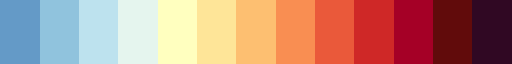

In [9]:
bounds, cmap = calc_bounds_cmap_PR_power(7, 'RdYlBu_r', skew=2)
print(bounds)
cmap

[0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]


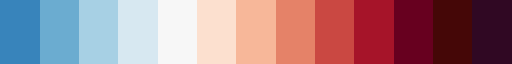

In [7]:
bounds, cmap = calc_bounds_cmap_PR_power(7, 'RdBu_r', skew=2)
print(bounds)
cmap

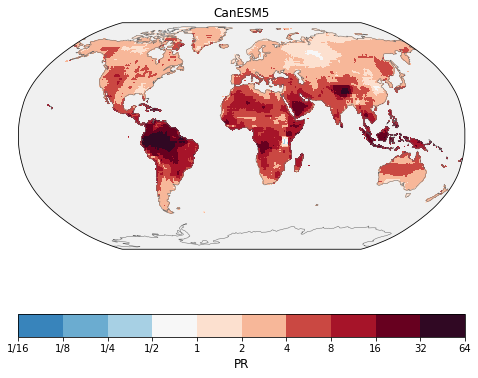

In [ ]:
plt.rcParams['text.usetex'] = False

# general fig 
fig = plt.figure(figsize=(8,8))
proj = ccrs.Robinson()

#inputs to functions
bounds, cmap = calc_bounds_cmap_PR_power(7, 'RdBu_r', skew=2)
landmask = get_mask()
smooth = 0.3
mask = True 

ax = plt.subplot(111, projection=proj)

# Make plot function for each GCM from here 
GCM = GCMs[0]

# settings
q = 0.99

# data 
outdir = get_outputpaths(GCM)[1]
data_pi_99 = xr.open_dataarray( glob.glob(os.path.join(outdir,  '{}*1850_1900.nc'.format(GCM.lower())) )[0], engine='netcdf4')
percentiles_pres_da = xr.open_dataarray(glob.glob(os.path.join(outdir, '{}*percentiles_pres_piTX99*.nc'.format(GCM.lower())))[0])
PR_da = (1 - percentiles_pres_da) / (1 - q)

# set params
title = '{}'.format(GCM)
cmap = cmap #try also RdBu_r
crs = ccrs.PlateCarree()

# define levels and cmap 
ticks = levels = bounds 
norm = colors.BoundaryNorm(levels, cmap.N)

# smooth and mask data
if mask == True:
    if not smooth == False: # if smooth is not false, smooth the data 
        data = PR_da 
        sigma = smooth
        da_plot = gaussian_filter(data, sigma) * landmask # smooth data for nicer plots?
    else:
        data = da_plot = PR_da * landmask
else:
    if not smooth == False: # if smooth is not false, smooth the data 
        data = PR_da 
        sigma = smooth
        da_plot = gaussian_filter(data, sigma) # smooth data for nicer plots?
    else:
        data = da_plot = PR_da   

#plot
plot = ax.contourf(data.lon, data.lat, da_plot, levels=levels, transform=crs, cmap=cmap, norm=norm)

# set title and coastlines
ax.set_title(title)
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_facecolor('#f0f0f0')


# For whole figure

# set colorbar and tick labels as fractions - fix this 
cbar_lab = 'PR' # try to get TeX interpreter 'less likely $\leftarrow$ PR $\rightarrow$ more likely' #'PR' # add more/less likely arrow 
cbar = fig.colorbar(plot, ticks=ticks, extend='both', location = 'bottom') 
labels = ['1/{}'.format(int(1/t)) if t<1 else str(t) for t in ticks]
cbar.ax.set_xticklabels(labels)
cbar.set_label(label=cbar_lab, size=12) 


In [34]:
# list comprehension
# [f(x) if condition else g(x) for x in sequence]
#  And, for list comprehensions with if conditions only,
# [f(x) for x in sequence if condition]

test = ['1/{}'.format(int(1/t)) if t<1 else str(t) for t in ticks]
test

['1/16', '1/8', '1/4', '1/2', '1', '2', '4', '8', '16', '32', '64']

## 1) PR: Smooth then mask

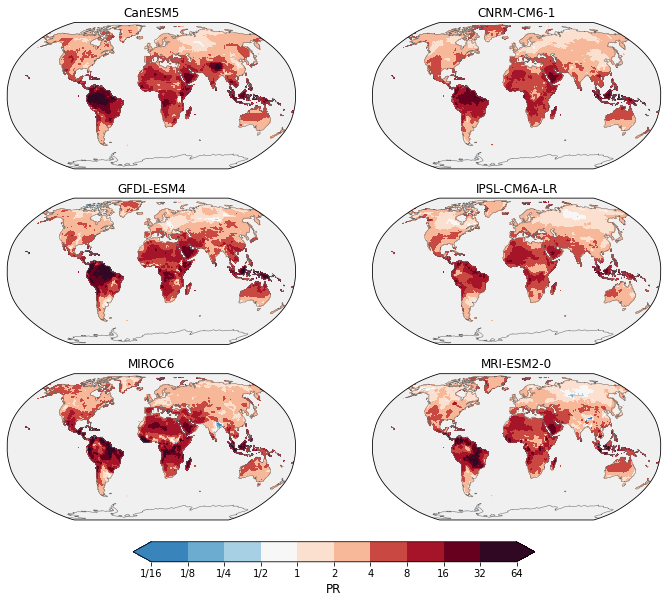

In [127]:

#inputs to functions
bounds, cmap = calc_bounds_cmap_PR_power(7, 'RdBu_r', skew=2)
landmask = get_mask()
smooth = 0.3
mask = True 

# make figure object
fig = plt.figure(figsize=(12,10))
proj = ccrs.Robinson()

#long
axes = [plt.subplot(321, projection=proj), plt.subplot(322, projection=proj), plt.subplot(323, projection=proj),
       plt.subplot(324, projection=proj), plt.subplot(325, projection=proj), plt.subplot(326, projection=proj)]

for GCM, ax in zip(GCMs, axes):
    plot = plot_PR(GCM, ax, cmap, bounds, smooth=0.3, mask=True)


cbar_lab = 'PR' # try to get TeX interpreter 'less likely $\leftarrow$ PR $\rightarrow$ more likely' #'PR' # add more/less likely arrow 
cbar = fig.colorbar(plot, ticks=ticks, extend='both', ax=axes, shrink=0.6, location='bottom', fraction= 0.045, pad= 0.04) #location='bottom' 
labels = ['1/{}'.format(int(1/t)) if t<1 else str(t) for t in ticks]
cbar.ax.set_xticklabels(labels)
cbar.set_label(label=cbar_lab, size=12) 
    
#fig.tight_layout()

#plt.savefig(os.path.join(figdir,'isimip3b_PR_TX99_RdBu_cbar.png'),dpi=300)
#plt.savefig(os.path.join(figdir,'isimip3b_PR_TX99_RdBu_cbar.pdf'),dpi=300)


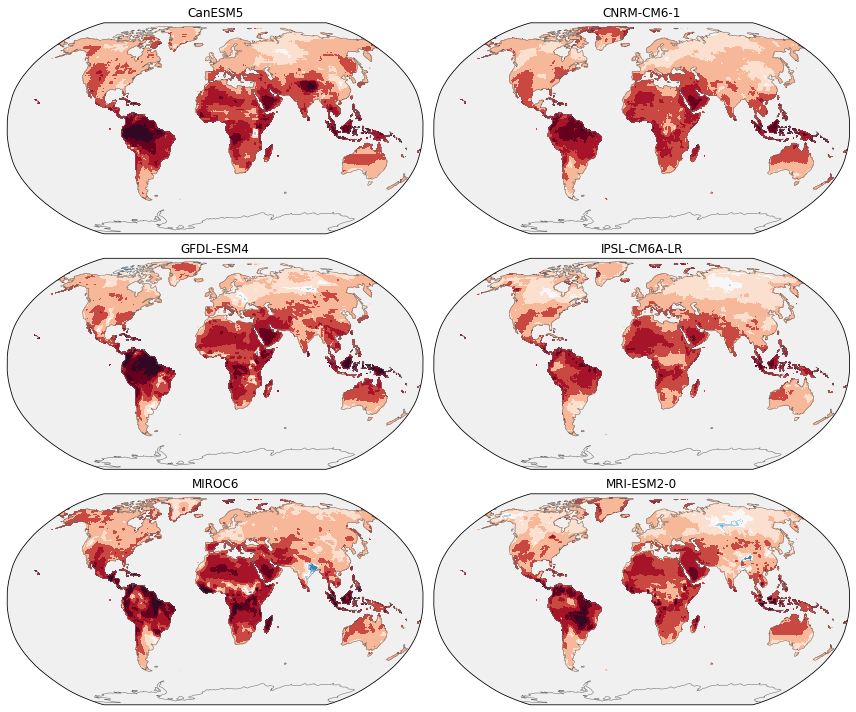

In [128]:
fig = plt.figure(figsize=(12,10))

axes = [plt.subplot(321, projection=proj), plt.subplot(322, projection=proj), plt.subplot(323, projection=proj),
       plt.subplot(324, projection=proj), plt.subplot(325, projection=proj), plt.subplot(326, projection=proj)]

for GCM, ax in zip(GCMs, axes):
    plot = plot_PR(GCM, ax, cmap, bounds, smooth=0.3, mask=True)

fig.tight_layout()

# TRY TO ADD CBAR TO LOOK DECENT ON THIS ONE (CAN'T REMEMBER WHAT WASN'T WORKING)

#plt.savefig(os.path.join(figdir,'isimip3b_PR_TX99_RdBu_tight_116_64_smo03.png'),dpi=300)
#plt.savefig(os.path.join(figdir,'isimip3b_PR_TX99_RdBu_tight_116_64_smo03.pdf'),dpi=300)


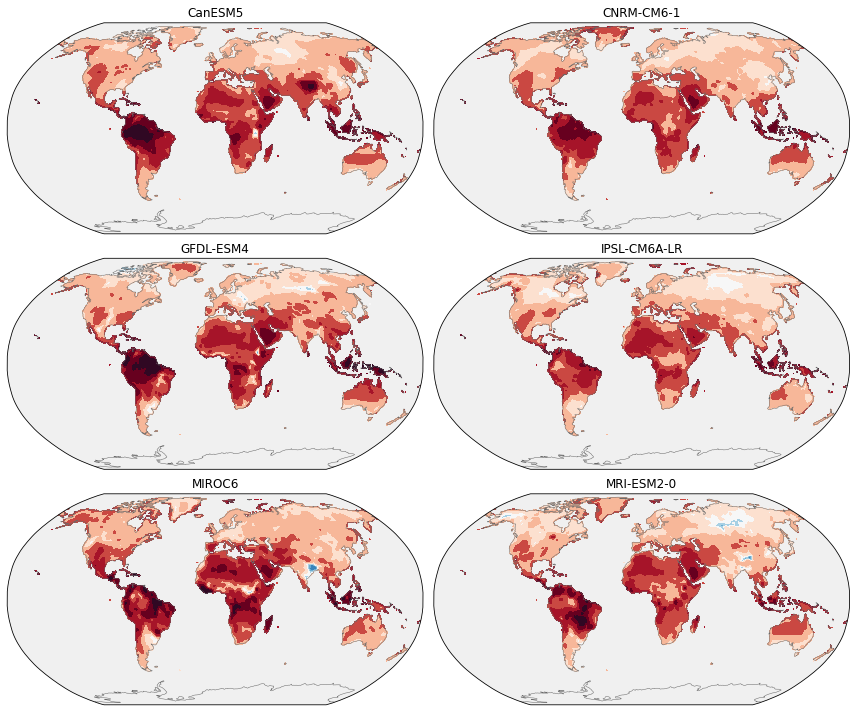

In [129]:
fig = plt.figure(figsize=(12,10))

axes = [plt.subplot(321, projection=proj), plt.subplot(322, projection=proj), plt.subplot(323, projection=proj),
       plt.subplot(324, projection=proj), plt.subplot(325, projection=proj), plt.subplot(326, projection=proj)]

for GCM, ax in zip(GCMs, axes):
    plot = plot_PR(GCM, ax, cmap, bounds, smooth=1.2, mask=True)

fig.tight_layout()

#plt.savefig(os.path.join(figdir,'isimip3b_PR_TX99_RdBu_tight_116_64_smo12.png'),dpi=300)
#plt.savefig(os.path.join(figdir,'isimip3b_PR_TX99_RdBu_tight_116_64_smo12.pdf'),dpi=300)


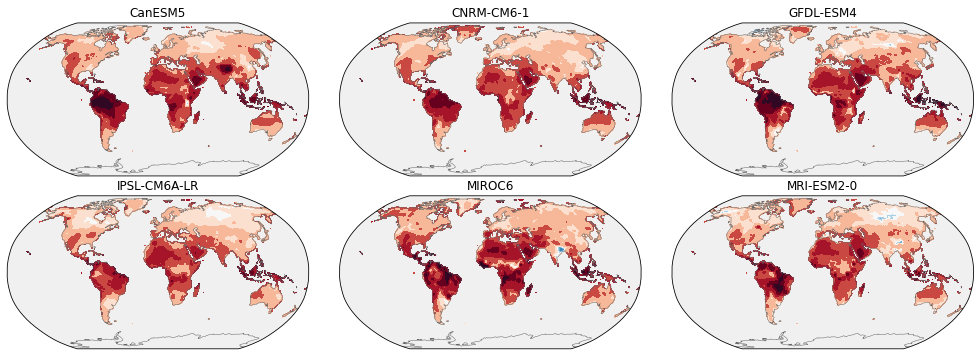

In [130]:
fig = plt.figure(figsize=(14,5))
axes = [plt.subplot(231, projection=proj), plt.subplot(232, projection=proj), plt.subplot(233, projection=proj),
       plt.subplot(234, projection=proj), plt.subplot(235, projection=proj), plt.subplot(236, projection=proj)]

for GCM, ax in zip(GCMs, axes):
    plot = plot_PR(GCM, ax, cmap, bounds, smooth=1.2, mask=True)
    
plt.tight_layout()

#plt.savefig(os.path.join(figdir,'isimip3b_PR_TX99_RdBu_tight_116_64_smo12_hor.png'),dpi=300)
#plt.savefig(os.path.join(figdir,'isimip3b_PR_TX99_RdBu_tight_116_64_smo12_hor.pdf'),dpi=300)


/apps/brussel/CO7/broadwell/software/xarray/2022.6.0-foss-2022a/lib/python3.10/site-packages/xarray/coding/times.py:682: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/apps/brussel/CO7/broadwell/software/xarray/2022.6.0-foss-2022a/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


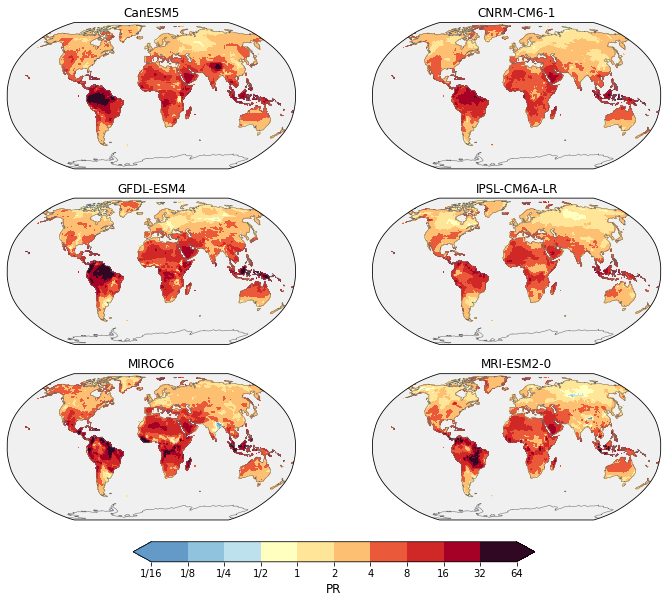

In [131]:

#inputs to functions
bounds, cmap = calc_bounds_cmap_PR_power(7, 'RdYlBu_r', skew=2)
landmask = get_mask()
smooth = 0.3
mask = True 

# make figure object
fig = plt.figure(figsize=(12,10))
proj = ccrs.Robinson()

#long
axes = [plt.subplot(321, projection=proj), plt.subplot(322, projection=proj), plt.subplot(323, projection=proj),
       plt.subplot(324, projection=proj), plt.subplot(325, projection=proj), plt.subplot(326, projection=proj)]

for GCM, ax in zip(GCMs, axes):
    plot = plot_PR(GCM, ax, cmap, bounds, smooth=0.3, mask=True)


cbar_lab = 'PR' # try to get TeX interpreter 'less likely $\leftarrow$ PR $\rightarrow$ more likely' #'PR' # add more/less likely arrow 
cbar = fig.colorbar(plot, ticks=ticks, extend='both', ax=axes, shrink=0.6, location='bottom', fraction= 0.045, pad= 0.04) #location='bottom' 
labels = ['1/{}'.format(int(1/t)) if t<1 else str(t) for t in ticks]
cbar.ax.set_xticklabels(labels)
cbar.set_label(label=cbar_lab, size=12) 
    
#fig.tight_layout()

#plt.savefig(os.path.join(figdir,'isimip3b_PR_TX99_RdYlBu_cbar.png'),dpi=300)
#plt.savefig(os.path.join(figdir,'isimip3b_PR_TX99_RdYlBu_cbar.pdf'),dpi=300)

# change yellow to blue transition !

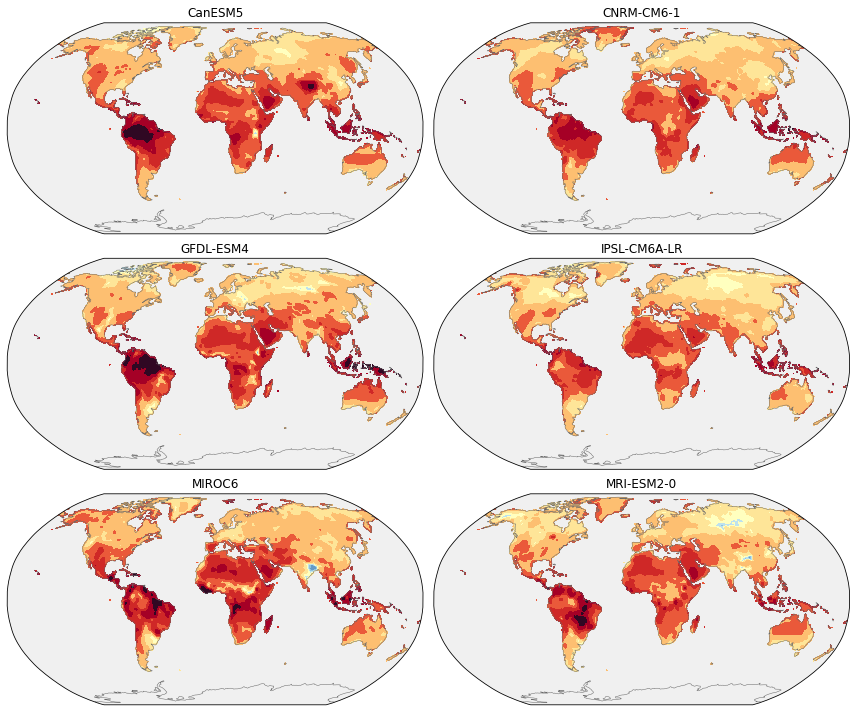

In [132]:
fig = plt.figure(figsize=(12,10))
#long 8,12
axes = [plt.subplot(321, projection=proj), plt.subplot(322, projection=proj), plt.subplot(323, projection=proj),
       plt.subplot(324, projection=proj), plt.subplot(325, projection=proj), plt.subplot(326, projection=proj)]

for GCM, ax in zip(GCMs, axes):
    plot = plot_PR(GCM, ax, cmap, bounds, smooth=1.2, mask=True)

fig.tight_layout()

#plt.savefig(os.path.join(figdir,'isimip3b_PR_TX99_RdYlBu_tight_116_64_smo12.png'),dpi=300)
#plt.savefig(os.path.join(figdir,'isimip3b_PR_TX99_RdYlBu_tight_116_64_smo12.pdf'),dpi=300)


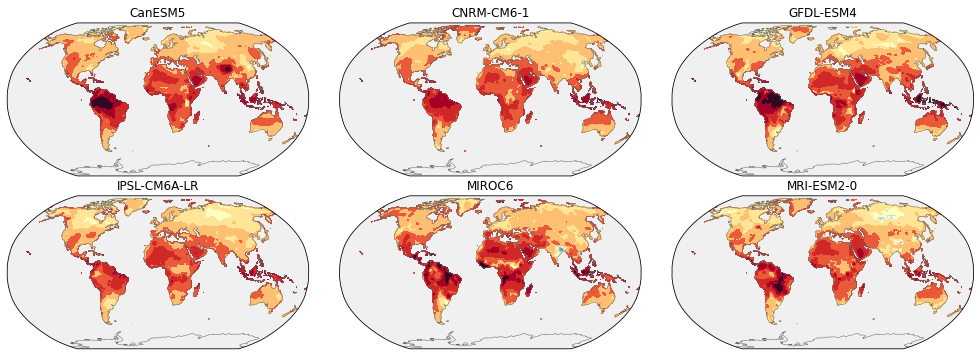

In [138]:
fig = plt.figure(figsize=(14,5))
axes = [plt.subplot(231, projection=proj), plt.subplot(232, projection=proj), plt.subplot(233, projection=proj),
       plt.subplot(234, projection=proj), plt.subplot(235, projection=proj), plt.subplot(236, projection=proj)]

for GCM, ax in zip(GCMs, axes):
    plot = plot_PR(GCM, ax, cmap, bounds, smooth=1.2, mask=True)
    
plt.tight_layout()

#plt.savefig(os.path.join(figdir,'isimip3b_PR_TX99_RdYlBu_tight_116_64_smo12_hor.png'),dpi=300)
#plt.savefig(os.path.join(figdir,'isimip3b_PR_TX99_RdYlBu_tight_116_64_smo12_hor.pdf'),dpi=300)


## Plot with the sea

## Plot multi-model mean /e(with and without the sea)

## delta I

In [18]:
#def plot_deltaI(GCM): 
gmstpath = glob.glob(os.path.join(datadirs, 'modified-data/warming-models/*ar6*.csv'))[0] # move this path to settings?
years =  get_years(gmstpath,GCM, 30 ) 

data_pi_99 = xr.open_dataarray( glob.glob(os.path.join(outdir,  '{}*1850_1900.nc'.format(GCM.lower())) )[0], engine='netcdf4')
data_pres_99 = xr.open_dataarray( glob.glob(os.path.join(outdir,  '{}*{}_{}.nc'.format(GCM.lower(),years[0], years[1])) )[0], engine='netcdf4')

mask = xr.open_dataarray('/data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/geo_conditions/landseamask/landseamask_no-ant.nc') # move this path to settings?
mask = mask[0,:,:].drop_vars('time')




## mask then smooth - no, not great / delete



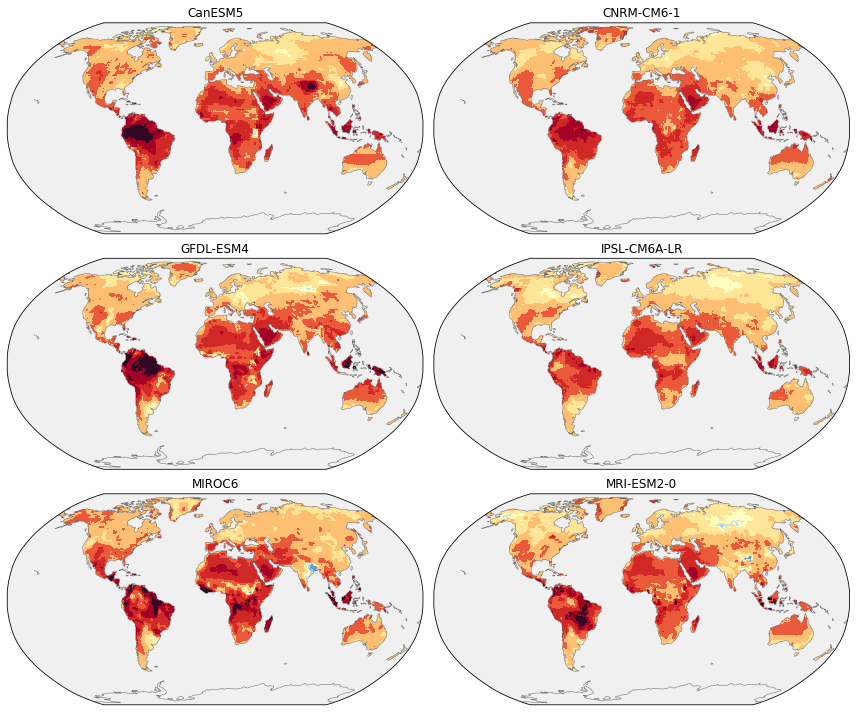

In [136]:
fig = plt.figure(figsize=(12,10))

axes = [plt.subplot(321, projection=proj), plt.subplot(322, projection=proj), plt.subplot(323, projection=proj),
       plt.subplot(324, projection=proj), plt.subplot(325, projection=proj), plt.subplot(326, projection=proj)]

for GCM, ax in zip(GCMs, axes):
    plot = plot_PR(GCM, ax, cmap, bounds, smooth=0.3, mask=True)

fig.tight_layout()

#plt.savefig(os.path.join(figdir,'isimip3b_PR_TX99_RdYlBu_tight_116_64_smo03_smo.png'),dpi=300)
#plt.savefig(os.path.join(figdir,'isimip3b_PR_TX99_RdYlBu_tight_116_64_smo03_smo.pdf'),dpi=300)


In [ ]:
# delete

# option 2 mask then smooth
def plot_PR(GCM, ax, cmap, bounds, smooth=False, mask=False):
    # settings
    q = 0.99
    
    # data 
    outdir = get_outputpaths(GCM)[1]
    data_pi_99 = xr.open_dataarray( glob.glob(os.path.join(outdir,  '{}*1850_1900.nc'.format(GCM.lower())) )[0], engine='netcdf4')
    percentiles_pres_da = xr.open_dataarray(glob.glob(os.path.join(outdir, '{}*percentiles_pres_piTX99*.nc'.format(GCM.lower())))[0])
    PR_da = (1 - percentiles_pres_da) / (1 - q)
    
    # set params
    title = '{}'.format(GCM)
    cmap = cmap #try also RdBu_r
    crs = ccrs.PlateCarree()
    
    # define levels and cmap 
    ticks = levels = bounds 
    norm = colors.BoundaryNorm(levels, cmap.N)
    
    # smooth and mask data
    if mask == True:
        if not smooth == False: # if smooth is not false, smooth the data 
            data = PR_da * landmask
            sigma = smooth
            da_plot = gaussian_filter(data, sigma) 
        else:
            data = da_plot = PR_da * landmask
    else:
        if not smooth == False: # if smooth is not false, smooth the data 
            data = PR_da 
            sigma = smooth
            da_plot = gaussian_filter(data, sigma) # smooth data for nicer plots?
        else:
            data = da_plot = PR_da   
    
    #plot
    plot = ax.contourf(data.lon, data.lat, da_plot, levels=levels, transform=crs, cmap=cmap, norm=norm, extend='both')
    
    # set title and coastlines
    ax.set_title(title)
    ax.coastlines(color='dimgray', linewidth=0.5)
    ax.set_facecolor('#f0f0f0')
    
    return plot 
